In [1]:
from manim import *
import jupyter_capture_output

video_scene = " -v WARNING --progress_bar None --disable_caching galvani_Scene"
image_scene = f" -v WARNING --progress_bar None --disable_caching -r {2*427},{2*240}  -s galvani_Scene"

Manim Community v0.18.0.post0

Jupyter Capture Output v0.0.11


In [211]:
# parameters of the system
k = 1                       # proportionality between current I and magnetic field B_coil
gamma = 0.5                 # friction coefficient
delta_t = 0.1               # time increment


# force on the needle by the magnetic field of the earth (depending on the angle)
def earth_magnetic_force(angle):
    return -np.sin(angle)


# force on the needly by the coil (depending on angle AND the electric current I)
def coil_magnetic_force(angle, I):
    return -k*I*np.sin(angle-PI/2)


# uses the state of the needle and the current I to calculate its next state
def next_state(state, I):

    angle = state[0]
    d_angle = state[1]
    dd_angle = earth_magnetic_force(angle) + coil_magnetic_force(angle, I) - gamma*d_angle

    a1 = np.array([d_angle, dd_angle])
    state[0] += a1[0]*delta_t + a1[1]*delta_t**2

    angle = state[0]
    dd_angle = earth_magnetic_force(angle) + coil_magnetic_force(angle, I) - gamma*d_angle

    a2 = np.array([d_angle, dd_angle])
    state[1] += (a1[1] + a2[1]) * delta_t / 2
    return state

In [270]:
class Compass(Mobject):
    def __init__(self, centre, radius, **kwargs):
        super().__init__(**kwargs)
        self.centre = centre
        self.radius = radius

        # circle with angels
        tick_width = 0.2
        angle_circle = Circle(radius = self.radius, color = BLACK, stroke_opacity = 0.5, stroke_width = 2).move_to(centre)
        angle_circle_out = Circle(radius = self.radius+tick_width, color = BLACK, stroke_opacity = 0.5, stroke_width = 2).move_to(centre)
        for i in range(8):
            angle = i*2*PI/8
            degree_angle = int(i/8*360)
            angle_tick = Line(start = centre+radius*UP, end = centre+(radius+tick_width)*UP, color = BLACK, stroke_opacity = 0.5, stroke_width = 2).rotate(about_point = self.centre, angle = angle)
            angle_tick_descriptor = Text(f"{degree_angle}", color = BLACK, fill_opacity = 0.5, font_size = 20).move_to(self.centre + (self.radius+2.75*tick_width)*(UP*np.cos(angle) + LEFT*np.sin(angle)))
            self.add(angle_tick, angle_tick_descriptor)
        self.add(angle_circle, angle_circle_out)


    # returns the needle for a given angle in rad
    def get_needle(self, angle):
        base_width = 0.5
        top_width = 0.2
        needle_radius = 0.95

        # center dot
        centre_dot = Circle(radius = self.radius/20, color = BLACK, fill_color = BLACK, fill_opacity = 0.5, stroke_opacity = 0.75).move_to(self.centre)
        
        # polygon edges
        base_left = self.centre + base_width/2*LEFT
        base_right = self.centre + base_width/2*RIGHT
        upper_left = self.centre + (needle_radius*self.radius)*UP + top_width/2*LEFT
        upper_right = self.centre + (needle_radius*self.radius)*UP + top_width/2*RIGHT
        lower_left = self.centre + (needle_radius*self.radius)*DOWN + top_width/2*LEFT
        lower_right = self.centre + (needle_radius*self.radius)*DOWN + top_width/2*RIGHT

        # lists of polygon edges
        top_position_list = [base_left, upper_left, upper_right, base_right]
        down_position_list = [base_left, lower_left, lower_right, base_right]
        # polygons
        upper_polygon = Polygon(*top_position_list, stroke_color = RED, fill_color = RED, fill_opacity = 0.5, stroke_opacity = 0)
        lower_polygon = Polygon(*down_position_list, stroke_color = BLUE, fill_color = GREEN, fill_opacity = 0.5, stroke_opacity = 0)

        # arcs
        arc_angle = 2*np.arcsin(top_width/2/needle_radius/self.radius)
        upper_arc = Arc(arc_center = self.centre, radius = needle_radius*self.radius, start_angle = PI/2-arc_angle/2, angle = arc_angle, fill_color = RED, stroke_color = BLACK, fill_opacity = 0.5, stroke_opacity = 0)
        lower_arc = Arc(arc_center = self.centre, radius = needle_radius*self.radius, start_angle = PI+PI/2-arc_angle/2, angle = arc_angle, fill_color = GREEN, stroke_color = BLACK, fill_opacity = 0.5, stroke_opacity = 0)
        return VGroup(upper_polygon, lower_polygon, upper_arc, lower_arc, centre_dot).rotate(about_point = self.centre, angle = angle)
    

    # get poles
    def get_poles(self):
        north = Text("North", color = RED, font_size = 32).move_to(self.centre + (self.radius + 1.25) * UP)
        south = Text("South", color = GREEN, font_size = 32).move_to(self.centre + (self.radius + 1.25) * DOWN)
        return VGroup(north, south)


class Coil(Mobject):
    def __init__(self, centre, height, width, **kwargs):
        super().__init__(**kwargs)
        self.centre = centre
        self.coil_height = height
        self.coil_width = width

        coil_rect = Rectangle(height = self.coil_height, width = self.coil_width, color = BLACK, fill_opacity = 0.25, stroke_opacity = 0).move_to(self.centre)
        self.add(coil_rect)

Output saved by overwring previous file at animations/galvanometre/galvanometre.mp4.


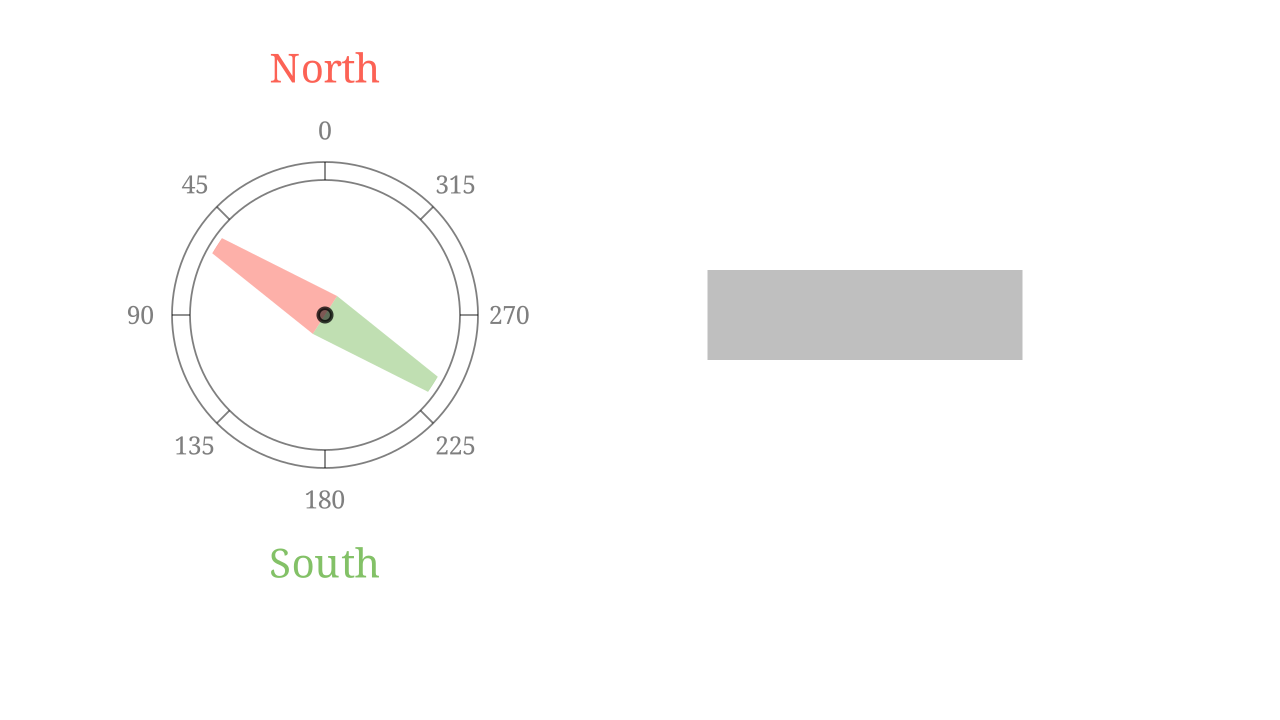

In [271]:
%%capture_video --path "animations/galvanometre/galvanometre.mp4"
%%manim -qm --fps 60 $video_scene


class galvani_Scene(Scene):
    def construct(self):
        self.camera.background_color = WHITE

        # value tracker running the current
        I_tracker = ValueTracker(0)

        # parameters
        compass_centre = np.array([-3.5, 0.5, 0])
        compass_radius = 1.5
        initial_angle = 1

        coil_centre = np.array([2.5, 0.5, 0])
        coil_height = 1
        coil_width = 3.5


        # compass
        compass = Compass(centre = compass_centre, radius = compass_radius)
        needle = compass.get_needle(initial_angle)
        poles = compass.get_poles()
        needle.state = np.array([initial_angle, 0.0])
        needle.current = I_tracker.get_value()
        self.add(compass, needle, poles)

        # coil
        coil = Coil(centre = coil_centre, height = coil_height, width = coil_width)
        self.add(coil)


        # updates the needle according to current and state
        def needle_updater(needle):
            state = needle.state                                        # get the current needle state
            current = I_tracker.get_value()                             # get current from value tracker
            new_state = next_state(state, current)                      # calculate the new state according to the old one and the current
            needle.state = new_state
            needle.become(galvanometre.get_needle(new_state[0]))

        
        # needle.add_updater(needle_updater)
        # self.play(I_tracker.animate.set_value(0), rate_func= linear, run_time = 5)
        # self.play(I_tracker.animate.set_value(10), rate_func= lambda x: x**2, run_time = 20)
        # self.play(I_tracker.animate.set_value(10), rate_func= linear, run_time = 5)